In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

# PLOTTING
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
import matplotlib.gridspec
import collections
import os
import math

# PYTORCH 
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import transforms, utils

In [3]:
from datasetFromFile import MidiSavedDataset
midi_train_dataset = MidiSavedDataset(data_type = "train")
midi_val_dataset   = MidiSavedDataset(data_type = "val")

In [4]:
trainloader = DataLoader(midi_train_dataset, batch_size=256,
                        shuffle=True, num_workers=6)
valloader   = DataLoader(midi_val_dataset, batch_size=256,
                        shuffle=True, num_workers=6)

In [5]:
def evaluate_metrics(preds, labels): 
    correct = 0.0
    total = 0.0
    num_true_pos_label  = 0.0
    num_false_pos_label = 0.0
    num_pos_pred  = 0.0
    num_true_neg_label  = 0.0
    num_false_neg_label = 0.0
    num_neg_pred  = 0.0

    num_timesteps = labels.shape[0]

    for i in range(num_timesteps): 
        for j in range(num_notes):
            if (labels[i,j] == 1.0):
                num_pos_pred += 1.0
            else: 
                num_neg_pred += 1.0

            if (preds[i,j] == labels[i,j]): 
                if (preds[i,j] == 1.0):
                    num_true_pos_label += 1.0
                else: 
                    num_true_neg_label += 1.0
                correct += 1.0
            else: 
                if (preds[i,j] == 1.0): 
                    num_false_pos_label += 1.0
                else: 
                    num_false_neg_label += 1.0
            total += 1.0
            
    accuracy = correct/total 
    recall = num_true_pos_label / num_pos_pred
    if (num_true_pos_label == 0 and num_false_pos_label == 0): 
        precision = 1
    else: 
        precision = num_true_pos_label/ (num_true_pos_label + num_false_pos_label)
    
    print("Correct: ", correct, ", Num pos: ", num_pos_pred, "num true pos: ", num_true_pos_label, "num false pos: ", num_false_pos_label, ", accuracy: ", accuracy, ", recall: ", recall)
    
    return accuracy, recall, precision

In [6]:
sigmoid = torch.nn.Sigmoid()

In [7]:
from models import Net
net = Net().cuda()

In [8]:
import torch.optim as optim
import torch.nn as nn

# criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCEWithLogitsLoss(pos_weight = torch.FloatTensor([2.0])).cuda()
optimizer = optim.SGD(net.parameters(), lr=1.0, momentum=0.9)

In [11]:
net = net.double()

train_loss_list = []
val_loss_list   = []

train_accuracy_list = []
val_accuracy_list   = []

train_recall_list = []
val_recall_list   = []

train_precision_list = []
val_precision_list = []

PLAYING_THRESH = 0.1

num_notes = 128

for epoch in range(5):  # loop over the dataset multiple times

    # TRAIN 
    sum_train_loss = 0
    train_labels = np.zeros((len(trainloader.dataset), num_notes))
    train_preds  = np.zeros((len(trainloader.dataset), num_notes))
    idx = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.double())
        loss = criterion(outputs, labels.double())
        loss.backward()
        optimizer.step()
        
        sum_train_loss += loss.item()
        
        train_labels[idx:idx+labels.shape[0], :] = labels.cpu().detach().numpy()
        train_preds[idx:idx+labels.shape[0], :]  = sigmoid(outputs.cpu().detach()).numpy()
        
        if (i % 100 == 0): 
            print("Iter: ", i, ", Loss: ", loss.item())
            

    # Get loss 
    avg_train_loss = sum_train_loss / len(trainloader)
    train_loss_list.append(avg_train_loss)
    
    # Get accuracy and recall 
    train_preds[train_preds <  PLAYING_THRESH] = 0
    train_preds[train_preds >= PLAYING_THRESH] = 1
    avg_train_accuracy, avg_train_recall, avg_train_precision = evaluate_metrics(train_preds, train_labels)
    train_accuracy_list.append(avg_train_accuracy)
    train_recall_list.append(avg_train_recall)
    train_precision_list.append(avg_train_precision)
    
    # print statistics
    print("Epoch: ", epoch, ", Train Loss: ", avg_train_loss, ", Train accuracy: ", avg_train_accuracy, ", Train recall: ", avg_train_recall, ", Train precision: ", avg_train_precision)
            
    # VALIDATE
    sum_val_loss = 0
    val_labels = np.zeros((len(valloader.dataset), num_notes))
    val_preds  = np.zeros((len(valloader.dataset), num_notes))
    with torch.no_grad():
        for i, data in enumerate(valloader,0):
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()
            outputs = net(inputs.double())
            loss = criterion(outputs, labels.double())

            sum_val_loss += loss.item()
            
            val_labels[idx:idx+labels.shape[0], :] = labels.cpu().detach().numpy()
            val_preds[idx:idx+labels.shape[0], :]  = sigmoid(outputs.cpu().detach()).numpy()

    # Loss 
    avg_val_loss = sum_val_loss / len(valloader)
    val_loss_list.append(avg_val_loss)
    
    # Get accuracy and recall  
    val_preds[val_preds <  PLAYING_THRESH] = 0
    val_preds[val_preds >= PLAYING_THRESH] = 1
    avg_val_accuracy, avg_val_recall, avg_val_precision = evaluate_metrics(val_preds, val_labels)
    val_accuracy_list.append(avg_val_accuracy)
    val_recall_list.append(avg_val_recall)
    val_precision_list.append(avg_val_precision)
    
    # print statistics
    print("Epoch: ", epoch, ", Val Loss: ", avg_val_loss, "\n")
        
print('Finished Training')

Iter:  0 , Loss:  0.16422588588161693
Correct:  395840.0 , Num pos:  192.0 num true pos:  0.0 num false pos:  0.0 , accuracy:  0.9995151906916613 , recall:  0.0
Epoch:  0 , Train Loss:  0.13000217765658678 , Train accuracy:  0.9995151906916613 , Train recall:  0.0 , Train precision:  1
Correct:  395911.0 , Num pos:  121.0 num true pos:  0.0 num false pos:  0.0 , accuracy:  0.9996944691338073 , recall:  0.0
Epoch:  0 , Val Loss:  0.07852781568188627 

Iter:  0 , Loss:  0.09586384847697324
Correct:  395406.0 , Num pos:  171.0 num true pos:  29.0 num false pos:  484.0 , accuracy:  0.9984193196509373 , recall:  0.1695906432748538
Epoch:  1 , Train Loss:  0.0743945855810575 , Train accuracy:  0.9984193196509373 , Train recall:  0.1695906432748538 , Train precision:  0.056530214424951264
Correct:  395184.0 , Num pos:  136.0 num true pos:  39.0 num false pos:  751.0 , accuracy:  0.9978587588881707 , recall:  0.2867647058823529
Epoch:  1 , Val Loss:  0.04819825789734582 

Iter:  0 , Loss:  0.0

### Loss

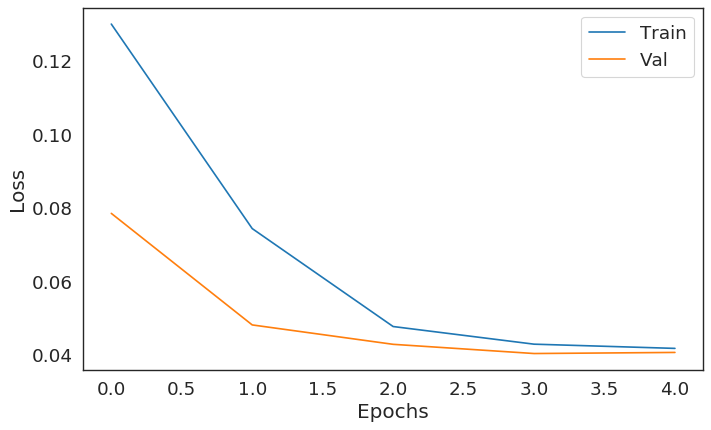

In [12]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_loss_list, label='Train')
plt.plot(val_loss_list,   label='Val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Recall 

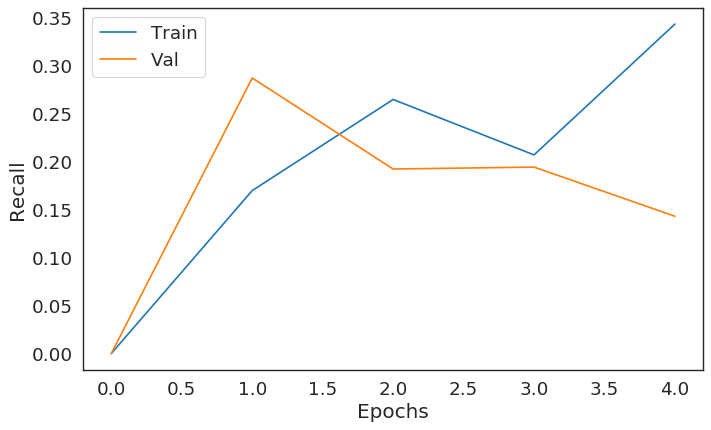

In [13]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_recall_list, label='Train')
plt.plot(val_recall_list,   label='Val')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

### Precision 

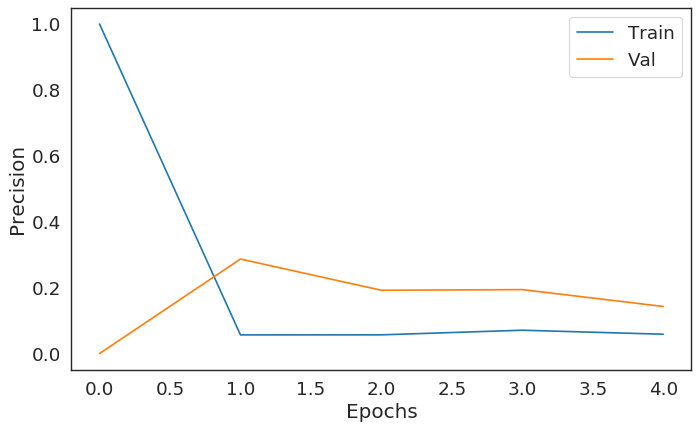

In [14]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_precision_list, label='Train')
plt.plot(val_recall_list,   label='Val')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()